Finding a frequency at which we can eliminate the inertial oscillations.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

def U_timeseries(dirname, fname, x_start, x_end, y_start, y_end):
    
    filesU = get_files(dirname, fname, 'grid_U')
    
    y = slice(y_start, y_end, None)
    x = slice(x_start, x_end, None)

    with scDataset(filesU) as dsU:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x]
        #print('U')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]

    umask = np.tile(umask0, (len(sozotaux),1, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    return vozocrtx, umask, depthu, sozotaux

def wind_timeseries(dirname):
    fname = "1_MCKNZ_1h_20170101_20170105_*"
    filesU = get_files(dirname, fname, 'grid_U')
    with scDataset(filesU) as dsU:
        sozotauxC = dsU.variables['sozotaux'][:,0,0]
        
    fname = "1_MCKNZ_1h_20170101_20170105_*"
    filesU = get_files(dirname, fname, 'grid_U')
    with scDataset(filesU) as dsU:
        sozotauxP = dsU.variables['sozotaux'][:,0,0]
        
    return sozotauxP, sozotauxC
    

def get_speeds(U_vel, V_vel, dep, time_ind, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[time_ind, dep, :, :]
    vgrid = V_vel[time_ind, dep, :, :]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return speeds

def load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end):
    
    # load masks for wheat in final plot
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask_all = dsM.variables['umask'][0,:,:,:]

    # load grid_U files and U velocity (t, z, y, x)
    vozocrtx, umask, depthu, sozotaux = U_timeseries(dirname, fname, x_start, x_end, y_start, y_end)

    return vozocrtx, umask, umask_all, depthu, sozotaux

def calculate_avgU(vozocrtx, dep_start, dep_end):

    # find avg U for every row in the y direction
    avgU_all_ys = np.mean(np.mean(vozocrtx, axis=-1), axis=-2)

    # find avg U within horizontal rectangle for all depths (time, z)
    avgU_all_depths = np.mean(np.mean(vozocrtx, axis=-1), axis=-1)

    # find avg U for every depth within the box
    avgU_box_depths = avgU_all_depths[:, dep_start : dep_end+1]

    # find the absolute avg U within the box
    avgU_absolute = np.mean(avgU_box_depths, axis=-1)
    
    return avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute

def plot_this_pair(axa, axb, plot_avgU, inds_absolute, ttl):
    cm_times = np.linspace(0, 1, plot_avgU.shape[-1])
    colors = [cm.Spectral_r(x) for x in cm_times]

    for ind, c, ind_absolute in zip(np.arange(plot_avgU.shape[-1]), colors, inds_absolute):
        if ind == 0 or ind == plot_avgU.shape[-1]-1:
            axa.plot(plot_avgU[:, ind], c=c, lw=2, label='ind = '+str(ind_absolute))
            axb.plot(general_functions.smooth(plot_avgU[:, ind], 12), c=c, lw=2, label='ind = '+str(ind_absolute))
        else:
            axa.plot(plot_avgU[:, ind], c=c, lw=2)
            axb.plot(general_functions.smooth(plot_avgU[:, ind], 12), c=c, lw=2)
            
    for ax, ttl_add in zip([axa, axb], [' (Original)', ' (Smoothed)']):
        ax.set_xlim([0, 120])
        ax.set_ylim([-0.3, 0.3])
        ml = MultipleLocator(24)
        ax.xaxis.set_minor_locator(ml)
        ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.set_title('Evolution of '+ttl+ttl_add, fontsize=20)
        ax.set_xlabel('Time [hrs]', fontsize=12)
        ax.legend(ncol=2, fontsize=15)
    return axa, axb

def plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute):
    cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

    xs = np.arange(umask_all.shape[-1]) * 2/3
    ys = np.arange(umask_all.shape[-2]) *2/3
    zs = np.arange(umask_all.shape[-3])

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])

    ax1 = plt.subplot(gs[0])
    ax4 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[3])

    s = ax1.pcolormesh(xs, ys, umask_all[9, :,:], cmap=cmap)
    ax1.set_aspect(aspect='equal')
    ax1.add_patch(patches.Rectangle((x_start*2/3, y_start*2/3),(x_end-x_start)*2/3,(y_end-y_start)*2/3, 
                                    fill=False, linewidth=3))
    ax1.set_xlim([0, xs[-1]])
    ax1.set_ylim([0, ys[-1]])
    ax1.set_xlabel('Alongshore Distance [km]', fontsize = 15)
    ax1.set_ylabel('Cross-shore Distance [km]', fontsize = 15)

    sc = ax3.pcolormesh(ys, zs, umask_all[:, :, x_start], cmap=cmap)
    ax3.add_patch(patches.Rectangle((y_start*2/3, dep_start),(y_end-y_start)*2/3, dep_end-dep_start, fill=False, linewidth=3))
    ax3.set_ylim([zs[-1], 0])
    ax3.set_xlim([0, ys[-1]])
    ax3.set_ylabel('Z Indices', fontsize = 15)
    ax3.set_xlabel('Cross-shore Distance [km]', fontsize = 15)

    avgU_absolute_smoothed = general_functions.smooth(avgU_absolute[:], 12)
    ax2.plot(avgU_absolute, c='gray', lw=2, alpha=0.8)
    ax2.plot(avgU_absolute_smoothed, c='k', lw=2)
    ax2.set_title('Incoming Velocity', fontsize=20)
    ax2.set_xlabel('Time [hours]', fontsize=15)
    ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
    ax2.set_xlim([0, 480])
    ax2.set_ylim([-0.3, 0.3])
    ml = MultipleLocator(24)
    ax2.xaxis.set_minor_locator(ml)
    ax2.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax2.axhline(0, linestyle='--', c='gray')

    ax4.plot(sozotaux, c='k', lw=2)
    ax4.set_title('Wind Stress', fontsize=20)
    ax4.set_xlabel('Time [hours]', fontsize=15)
    ax4.set_ylabel('[Nm$^{-2}$]', fontsize=20)
    ax4.set_xlim([0, 480])
    ax4.set_ylim([-1.0, 1.0])
    ml = MultipleLocator(24)
    ax4.xaxis.set_minor_locator(ml)
    ax4.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax4.axhline(0, linestyle='--', c='gray')

    fig.tight_layout(w_pad=5.5, h_pad=3.5)
    
    print('min unsmoothed: ', avgU_absolute.min())
    print('min smoothed: ', avgU_absolute_smoothed.min())
    return fig

In [3]:
x_start = 200; x_end = 230; y_start = 45; y_end = 190

dep_start = 2; dep_end = 6; dep_break = 9

# Original NEMO function for wind stress
* Wind stress -1.2
* nn_tau000 = 36000 (10 h)
* nn_tau002 = 259200 (72 h)

        nn_tau000_step = nn_tau000 / rn_rdt
    
        IF kt <= nn_tau000_step

            utau = rn_utau0 { 1/2 [ 1 - cos( 4/3 pi * kt * rn_rdt / nn_tau000) ] }

In [4]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/stress_1.2_runF/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

avgU_all_ys.shape, avgU_all_depths.shape, avgU_box_depths.shape, avgU_absolute.shape

((120, 145), (120, 80), (120, 5), (120,))

min unsmoothed:  -0.37209639262
min smoothed:  -0.213032888388


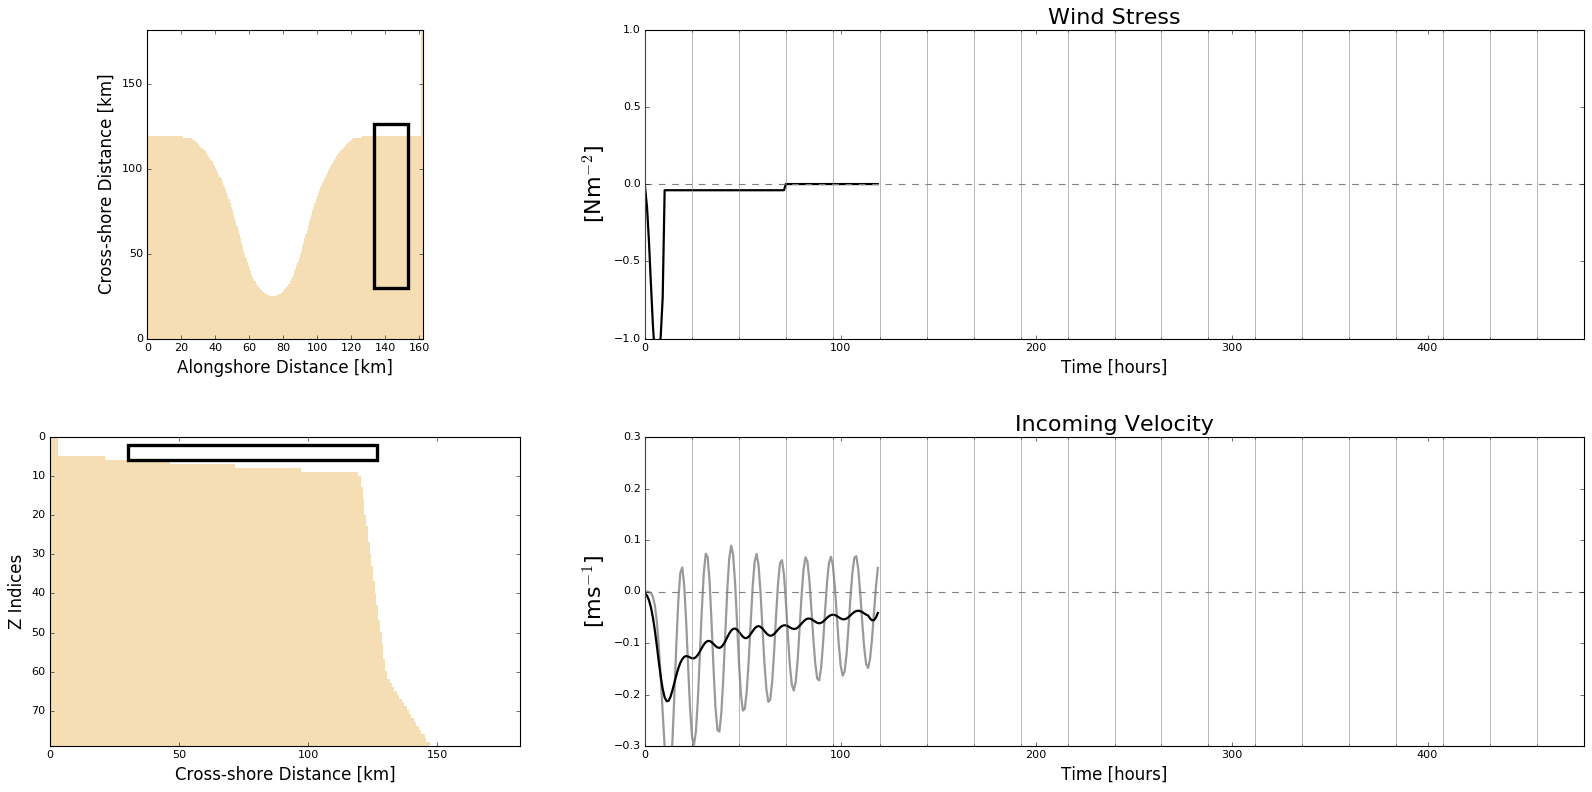

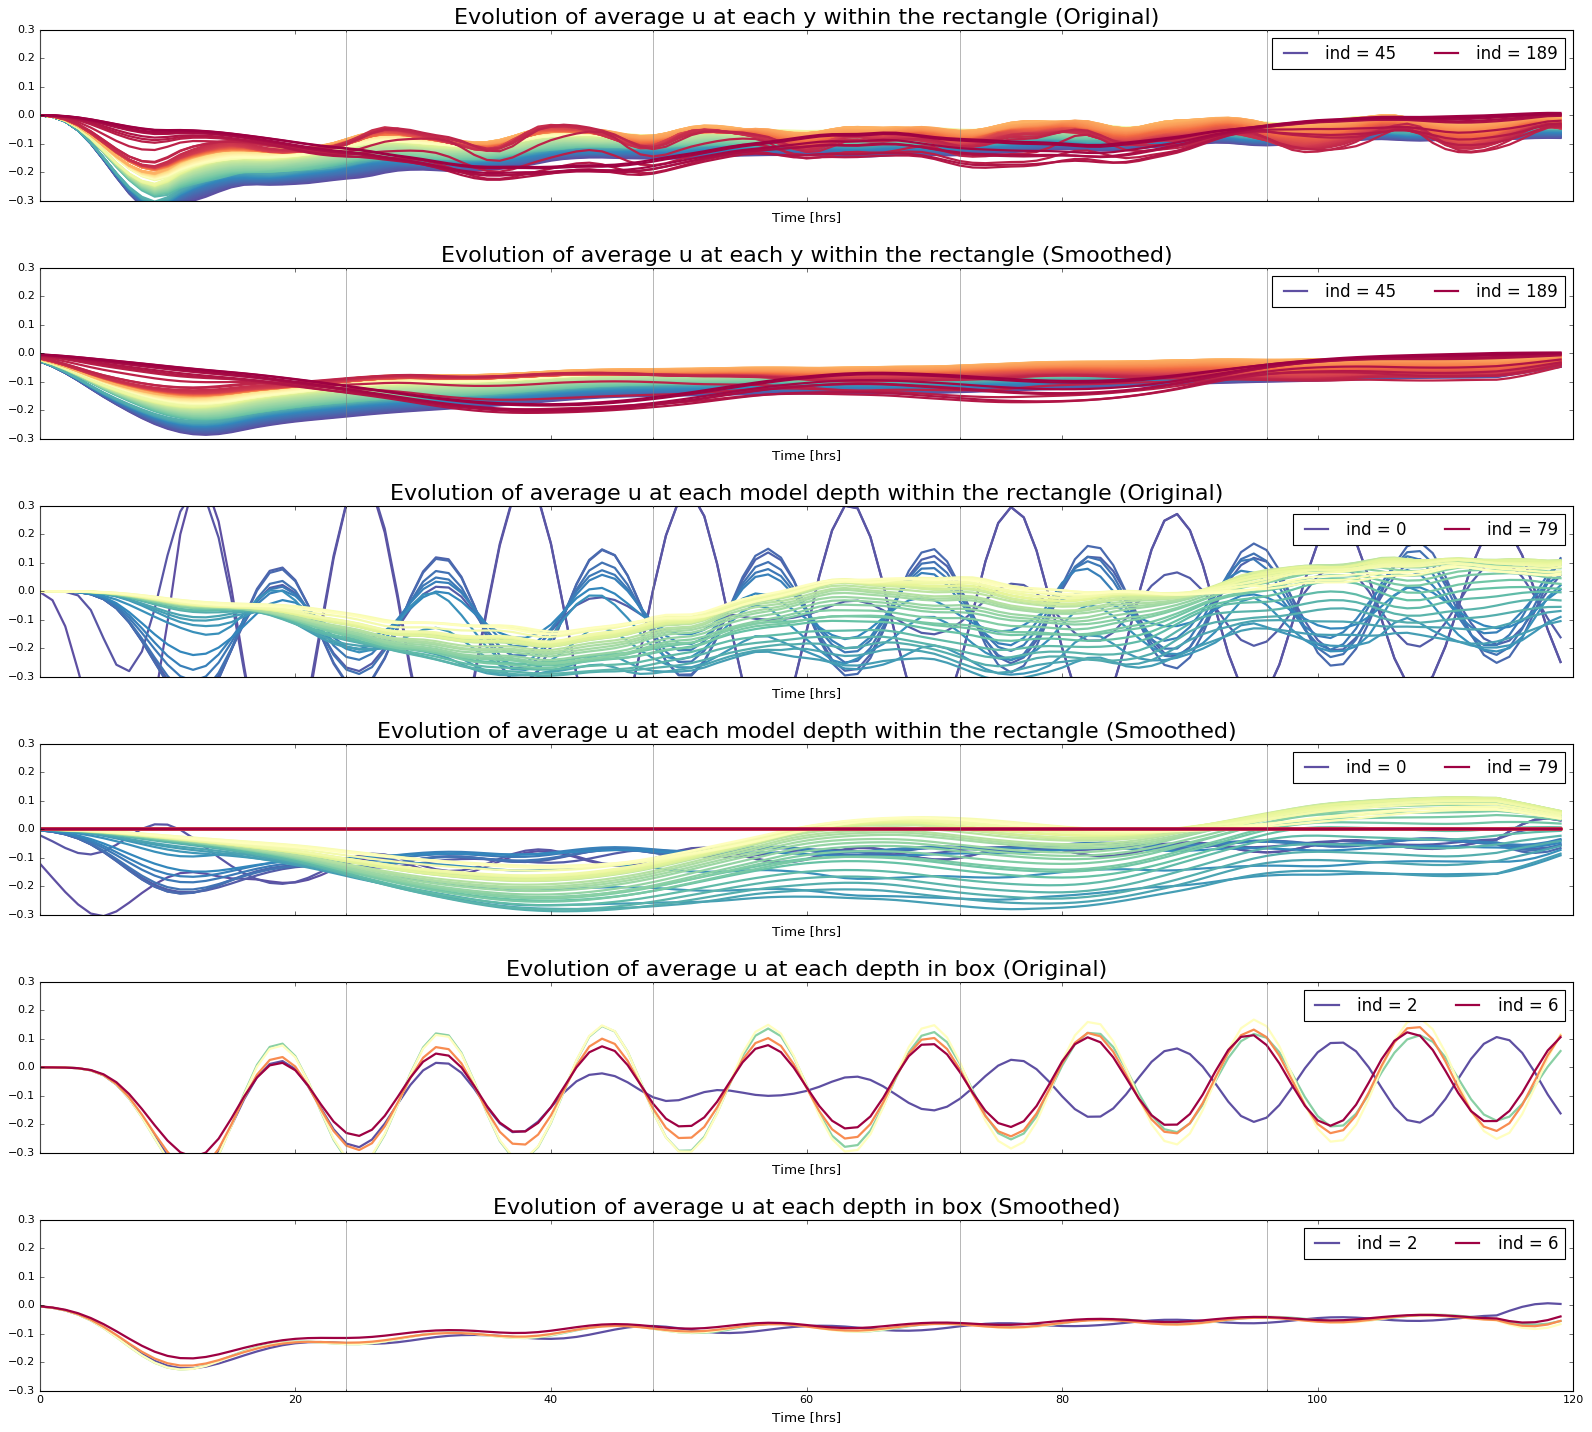

In [5]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1,figsize=(20, 18), sharex=True)

ax1, ax2 = plot_this_pair(ax1, ax2, avgU_all_ys, y_inds, 'average u at each y within the rectangle')
ax3, ax4 = plot_this_pair(ax3, ax4, avgU_all_depths, dep_inds_model, 'average u at each model depth within the rectangle')
ax5, ax6 = plot_this_pair(ax5, ax6, avgU_box_depths, dep_inds_box, 'average u at each depth in box')
fig.tight_layout(h_pad=2)

# First try at cosine (Accidental short step)
* rn_utau0 -1.2
* nn_tau000 = 36000 (10 h)
* nn_tau002 = 259200 (72 h)

        nn_tau000_step = nn_tau000 / rn_rdt

        IF kt <= nn_tau000_step

            utau = rn_utau0 { 1/2 [ 1- cos ( f * kt * rn_rdt / 4 pi ) ] }

        Where f = 1.373 x 10^-4

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_originalA/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

min unsmoothed:  -0.0585362461593
min smoothed:  -0.0572477307419


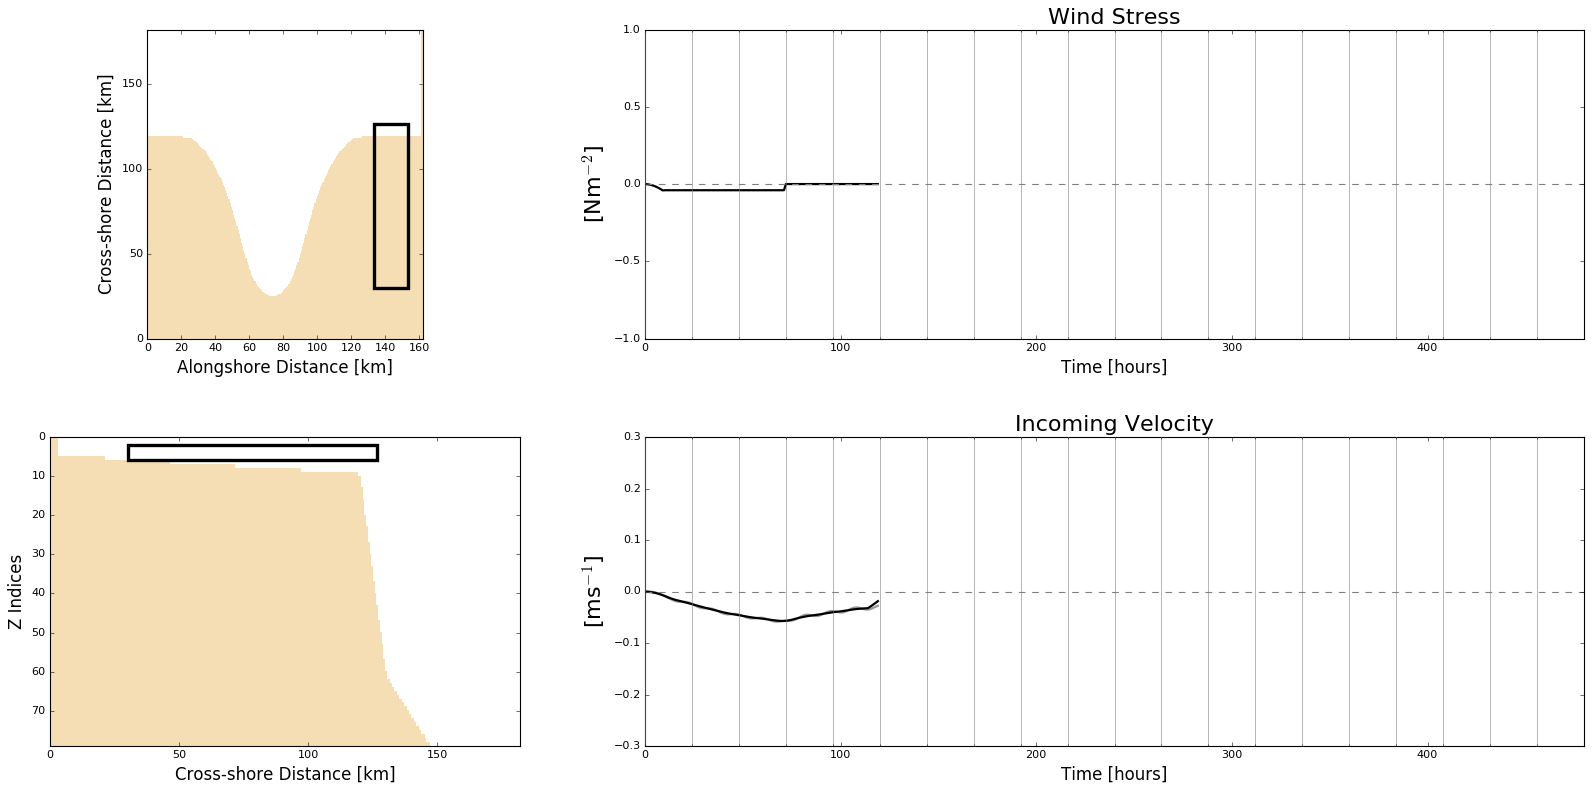

In [7]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

In [8]:
grid_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/grid_for_agrif.nc')
grid_lats = grid_file['grid_lats'][:]
print('mean latitude', np.mean(grid_lats))
print('max kt aka nn_tau000', 4 * np.pi / 0.0001373)

mean latitude 70.7002065123
max kt aka nn_tau000 91524.91343306025


# First try at cosine (4$\pi$/f step)

* rn_utau0 = -1.2
* nn_tau000 = 91440 (25.4 h)
* nn_tau002 = 259200 (3 d)

            utau = rn_utau0 { 1/2 [ 1 - cos ( f * kt * rn_rdt / 4 pi ) ] }

In [9]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_originalB/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

min unsmoothed:  -0.0941407824364
min smoothed:  -0.0721350507399


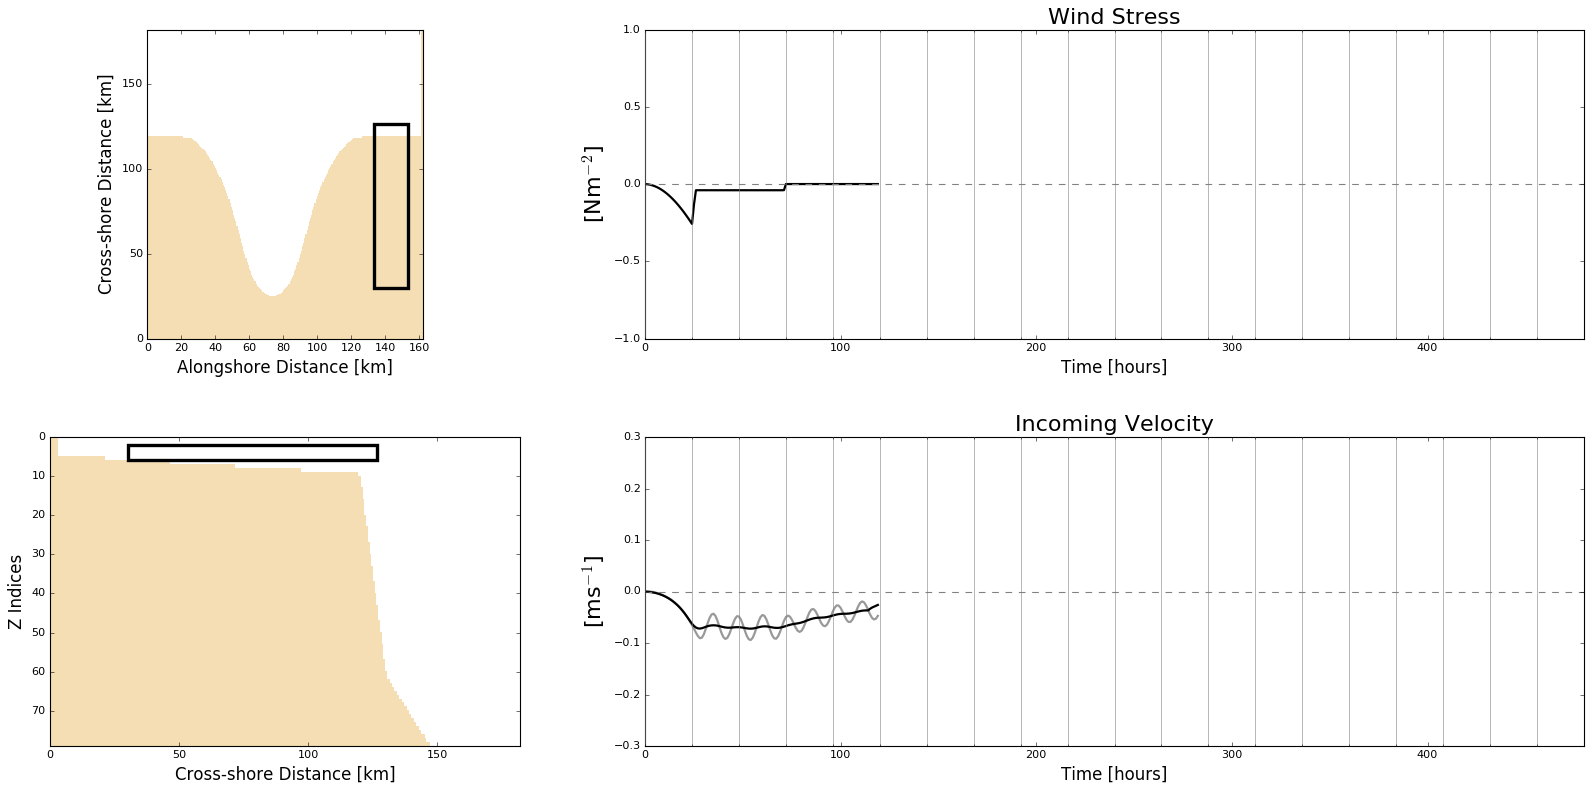

In [10]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

# Cosine with period 4$\pi$/f (original stress)
* rn_utau0 = -1.2
* nn_tau000 = 91440 (25.4 h)
* nn_tau002 = 259200 (3 d)

        nn_tau000_step = nn_tau000 / rn_rdt

        where nn_tau000 = 4 pi / f

        IF kt <= nn_tau000_step

            utau = rn_utau0 { 1/2 [ 1 - cos ( f * kt * rn_rdt / 2 ) ] }

In [11]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_new_1.2/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

min unsmoothed:  -0.390441023994
min smoothed:  -0.341979446492


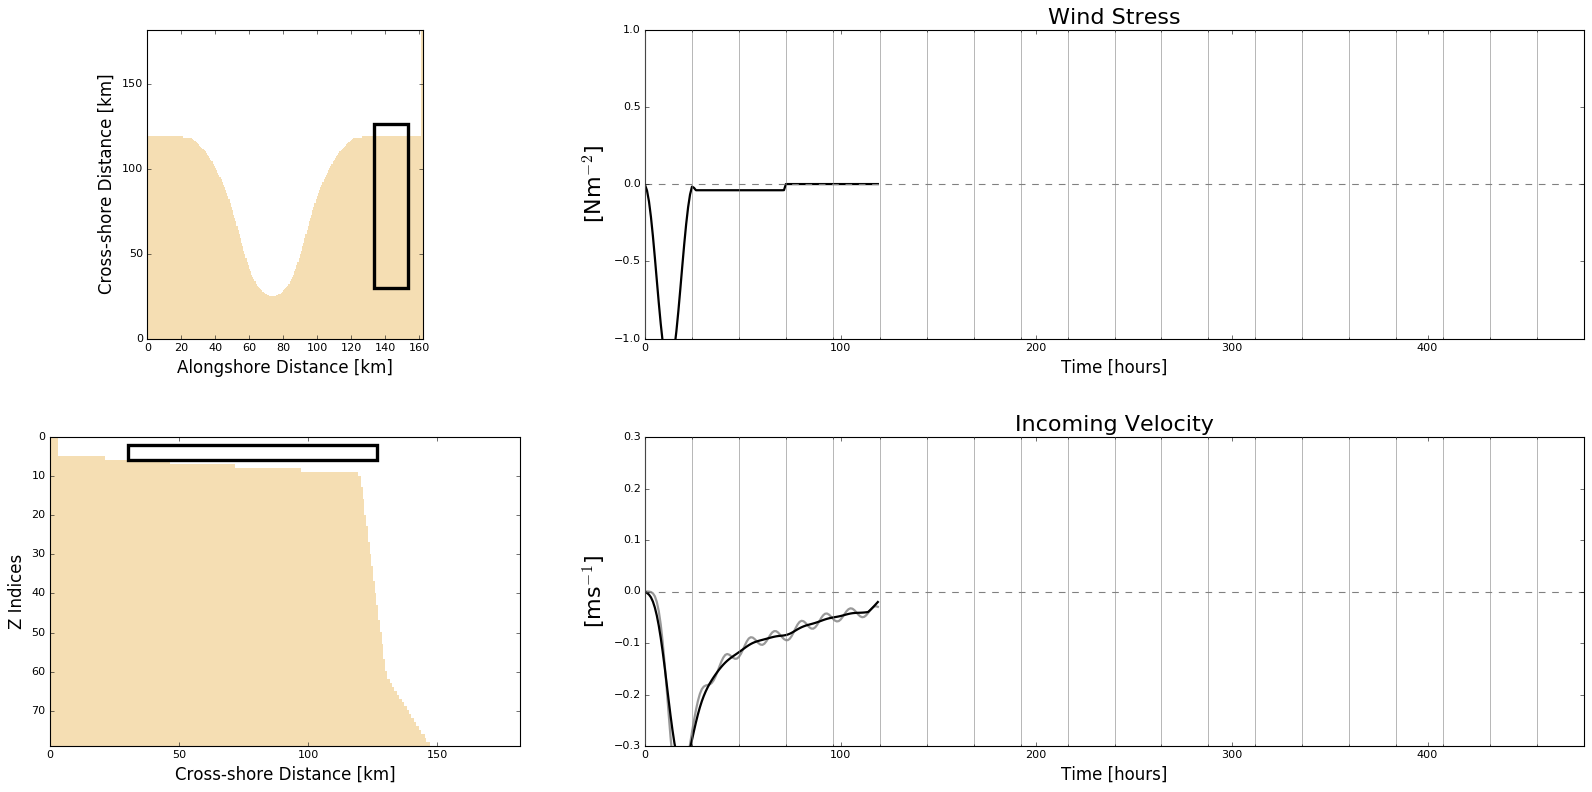

In [12]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

# Cosine with period 4$\pi$/f (half stress)
* rn_utau0 = -0.6
* nn_tau000 = 91440 (25.4 h)
* nn_tau002 = 259200 (3 d)

        utau = rn_utau0 { 1/2 [ 1 - cos ( f * kt * rn_rdt / 2 ) ] }

In [13]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_new_0.6/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

min unsmoothed:  -0.204226027713
min smoothed:  -0.182031915624


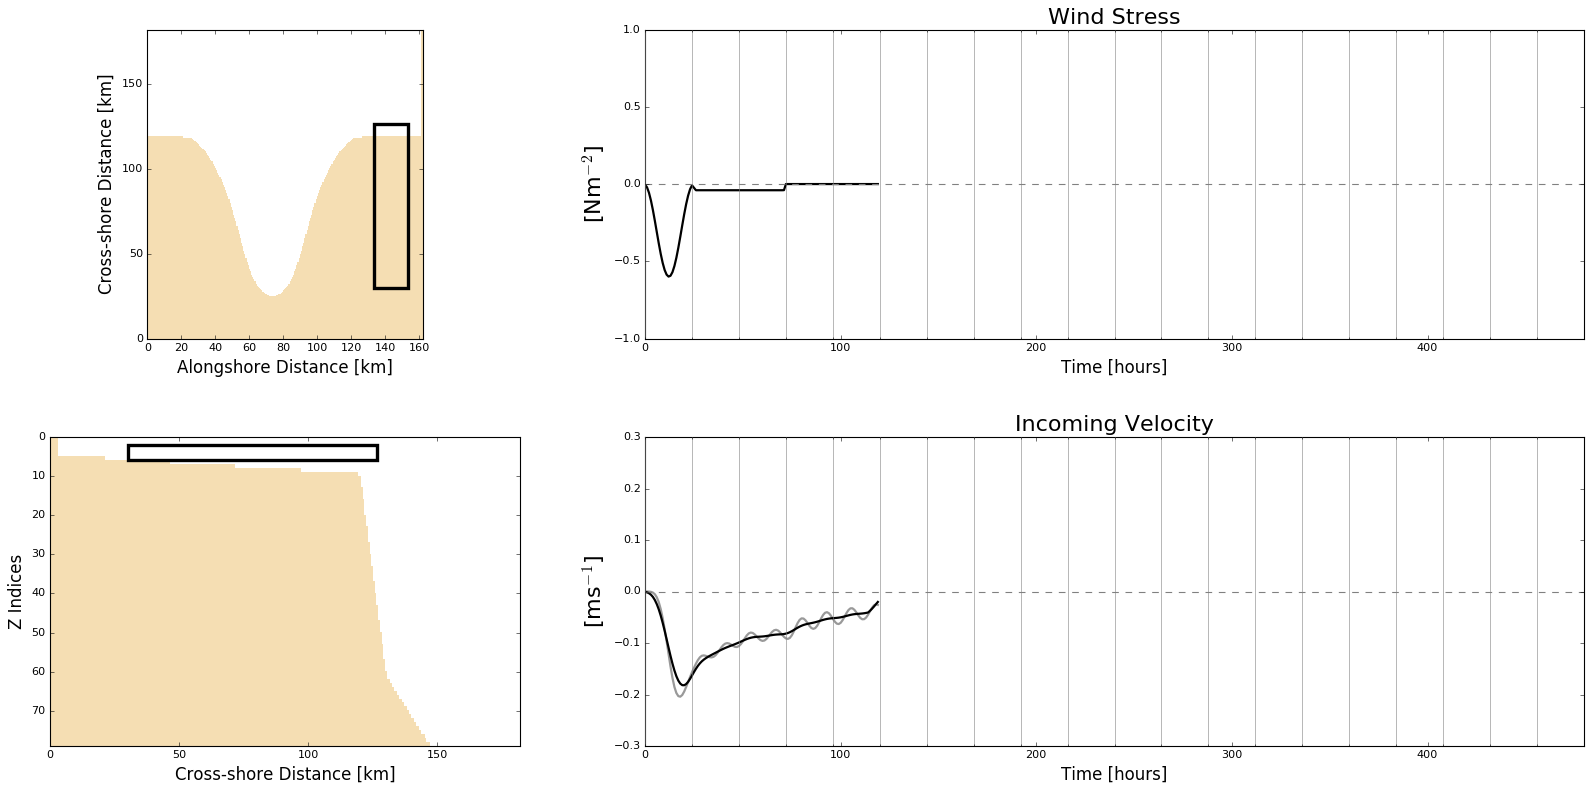

In [14]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

# Cosine with period 4$\pi$/f (medium stress, no step)
* rn_utau0 = -0.8
* nn_tau000 = 91440 (25.4 h)
* nn_tau002 = 259200 (3 d)

        utau = rn_utau0 { 1/2 [ 1 - cos ( f * kt * rn_rdt / 2 ) ] }

In [15]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_new_0.8/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

min unsmoothed:  -0.269124020121
min smoothed:  -0.238002123882


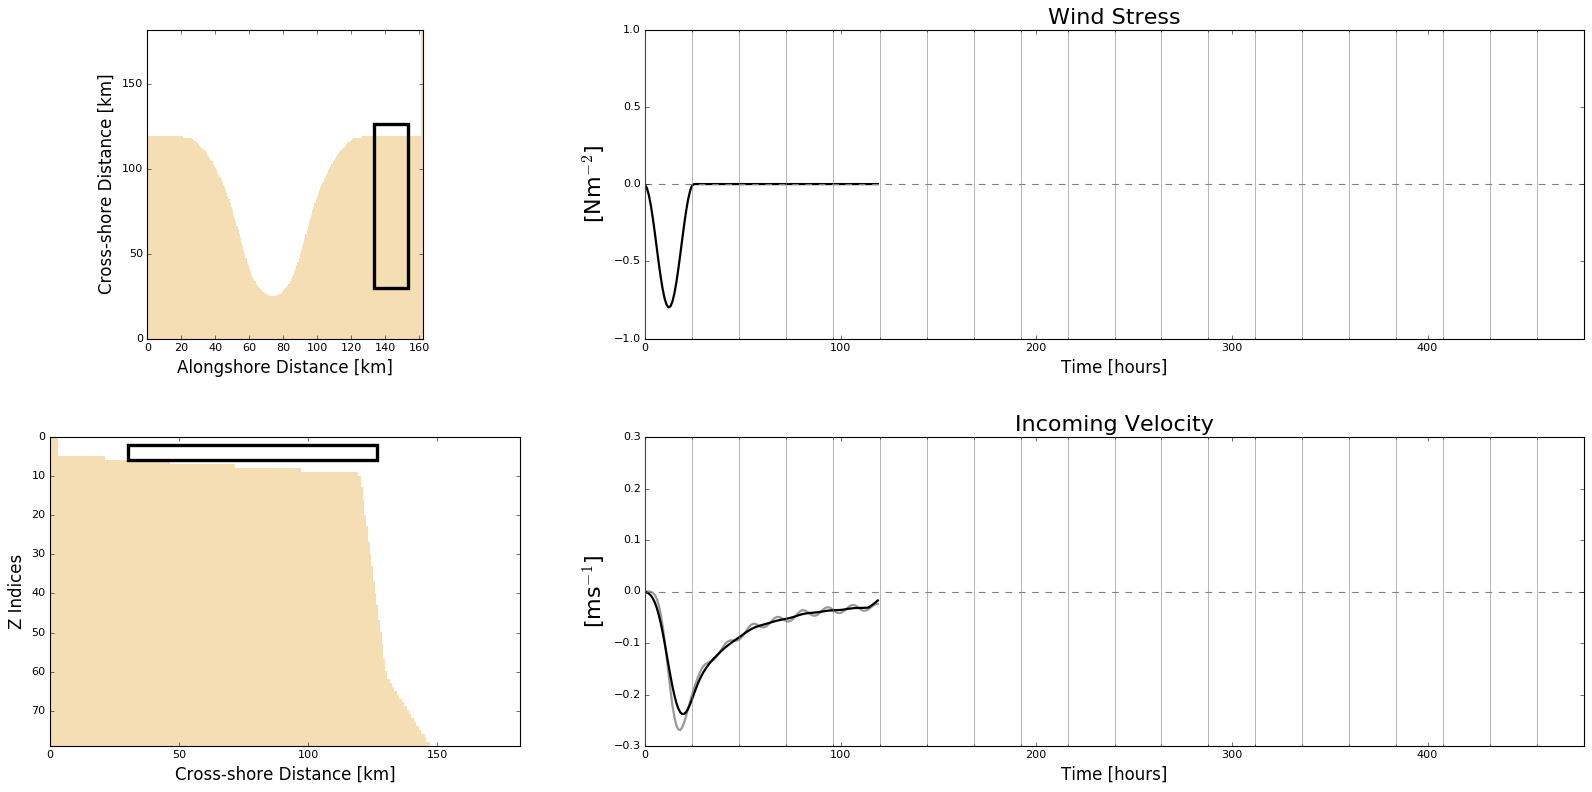

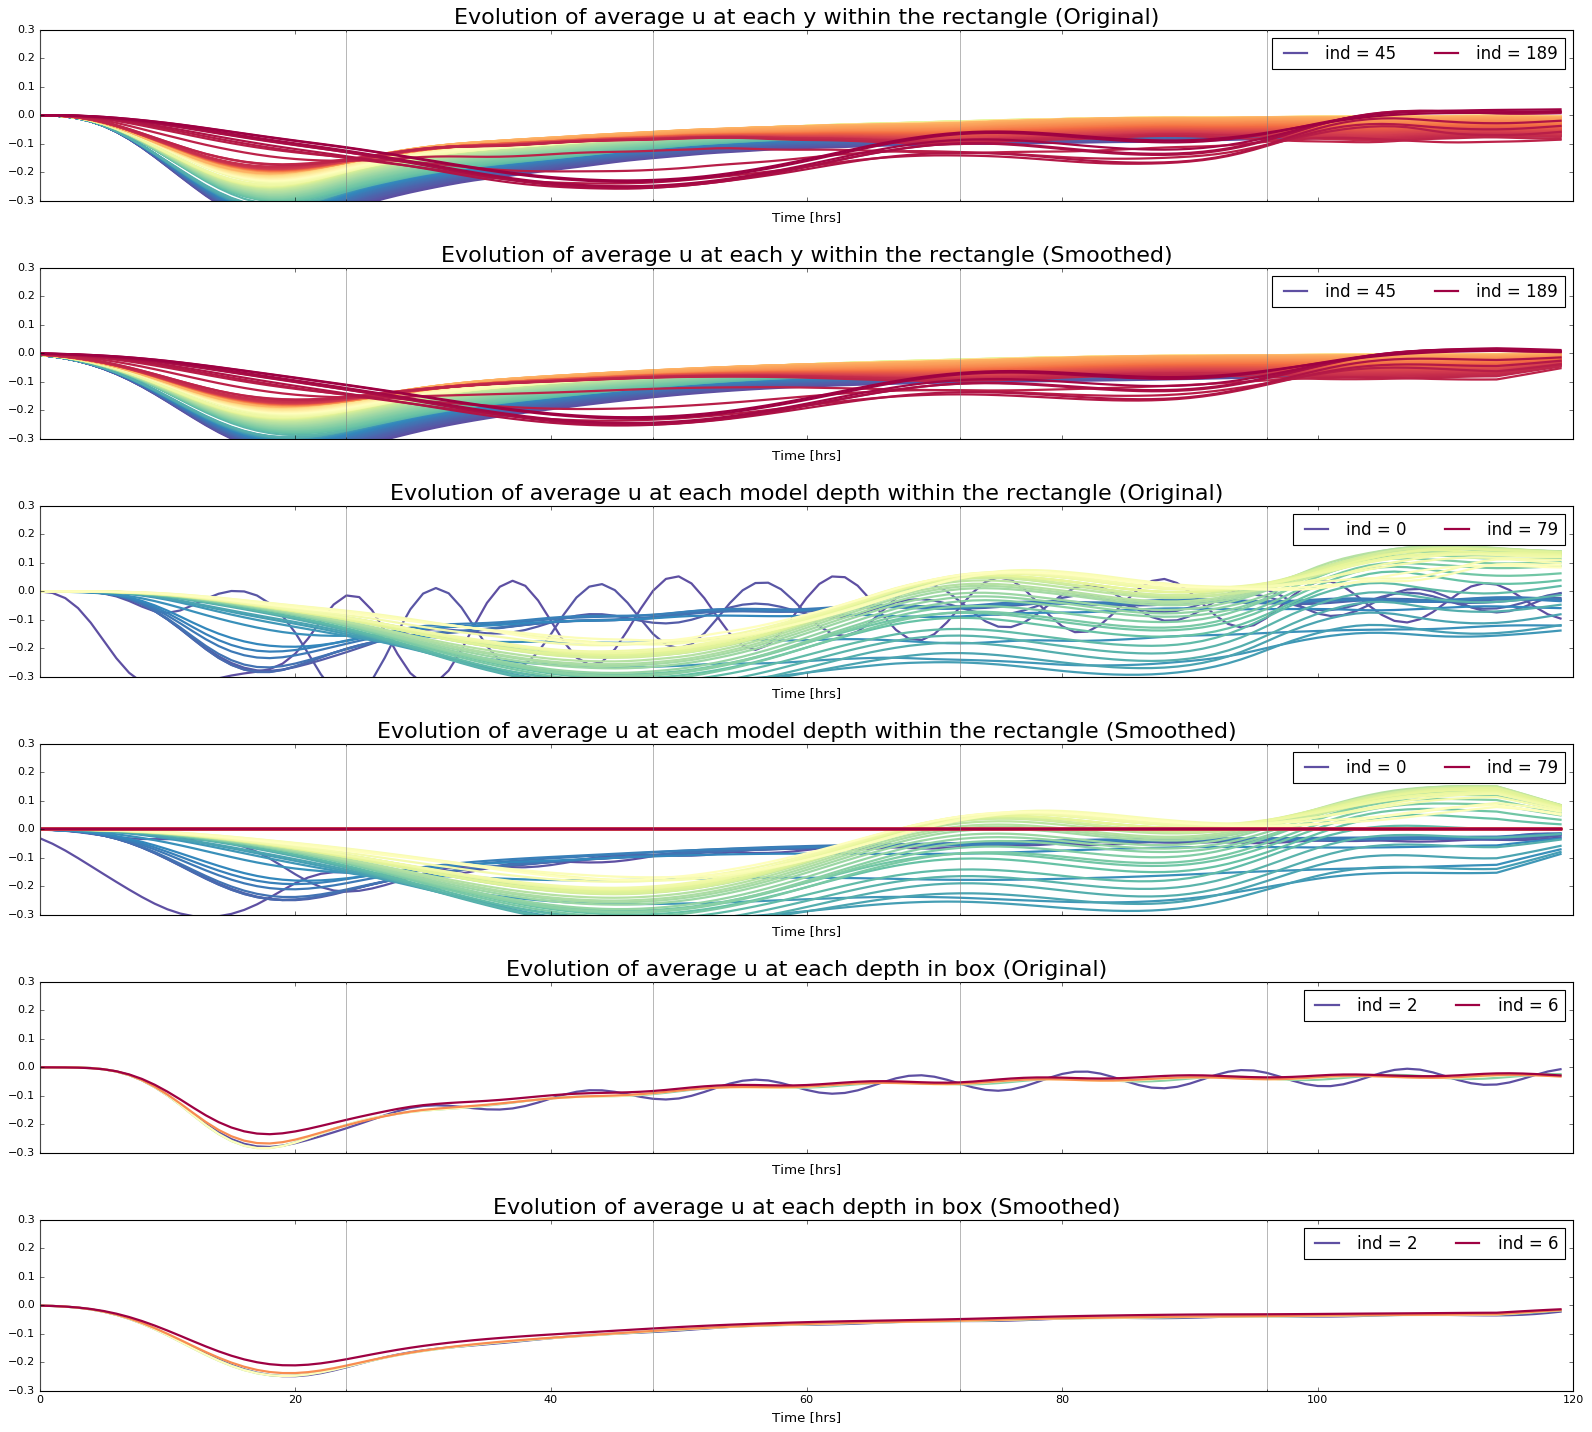

In [16]:
fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1,figsize=(20, 18), sharex=True)

ax1, ax2 = plot_this_pair(ax1, ax2, avgU_all_ys, y_inds, 'average u at each y within the rectangle')
ax3, ax4 = plot_this_pair(ax3, ax4, avgU_all_depths, dep_inds_model, 'average u at each model depth within the rectangle')
ax5, ax6 = plot_this_pair(ax5, ax6, avgU_box_depths, dep_inds_box, 'average u at each depth in box')
fig.tight_layout(h_pad=2)

# Cosine with tanh tail

### Previous
    
    IF( MOD( kt - 1, nn_fsbc ) == 0 ) THEN
         !
         IF( kt <= nn_tau000_step ) THEN       ! Increase the stress to its nominal value
            !                             ! during the first nn_tau000 time-steps
            !zfact = 0.5 * (  1. - COS( rpi * REAL( kt, wp ) / ( REAL( nn_tau000_step, wp ) / 1.5 ) )  )
            !zfact = 0.5 * (  1. - COS( ( 0.0001373 * REAL( kt, wp ) * rn_rdt ) / ( 4 * rpi ) ) )
            zfact = 0.5 * (  1. - COS( ( 0.0001373 * REAL( kt, wp ) * rn_rdt ) / ( 2 ) ) )
            zcoef = 1. / ( zrhoa * zcdrag )
            ztx   = zfact * rn_utau0
            zty   = zfact * rn_vtau0
            zmod  = SQRT( ztx * ztx + zty * zty )
            utau(:,:) = ztx
            vtau(:,:) = zty
            taum(:,:) = zmod
            zmod = SQRT( zmod * zcoef )
            wndm(:,:) = zmod
         ENDIF

             IF( kt > nn_tau000_step ) THEN
            thickness_of_tanh = ABS(rn_utau2 - rn_utau1)
            amplitude_of_tanh = 0.5 * thickness_of_tanh
            distance_to_move = ABS(rn_utau1 - (-1 * amplitude_of_tanh))
            tanh_final = (amplitude_of_tanh * TANH( REAL( kt, wp ) - nn_tau002_step ) ) - distance_to_move
            utau(:,:) = tanh_final
         ENDIF

### Attempts A to D

	 ! Calculating variables to keep winds same for parent and child IAM
         nn_tau000_step = nn_tau000 / rn_rdt
         xm = INT ( nn_tau000_step * 0.8 )
         dx = INT ( nn_tau000_step * 0.25 )

      ENDIF

      IF( MOD( kt - 1, nn_fsbc ) == 0 ) THEN 
         !
         IF( kt <= xm ) THEN            
            zfact = 0.5 * (  1. - COS( ( 0.0001373 * REAL( kt, wp ) * rn_rdt ) / ( 2 ) ) )
            zcoef = 1. / ( zrhoa * zcdrag ) 
            ztx   = zfact * rn_utau0
            zty   = zfact * rn_vtau0
            zmod  = SQRT( ztx * ztx + zty * zty )
            utau(:,:) = ztx
            vtau(:,:) = zty
            taum(:,:) = zmod
            zmod = SQRT( zmod * zcoef )
            wndm(:,:) = zmod
         ENDIF

      IF( kt > xm ) THEN
            zfact = 0.5 * (  1. - COS( ( 0.0001373 * REAL( xm, wp ) * rn_rdt ) / ( 2 ) ) )
            ztx   = zfact * rn_utau0
            ym    = ztx
            tanh_fxn = ym + ( ( -1. * ym ) * TANH ( ( REAL( kt, wp ) - xm ) / dx ) )
            utau(:,:) = tanh_fxn
         ENDIF

|fraction of|xm   |dx   |results|
|-----------|-----|-----|-------|
|A          |0.8  | 0.25|       |
|B0         |0.8  | 0.4 |same as A|
|B1         |0.6  | 0.25|drops abruptly|
|B          |0.6  | 0.5 |almost same as B1 |
|C          |0.6  | 1.5 |       |
|D          |0.95 | 1.5 |       |




min unsmoothed:  -0.269127852419
min smoothed:  -0.23630556821


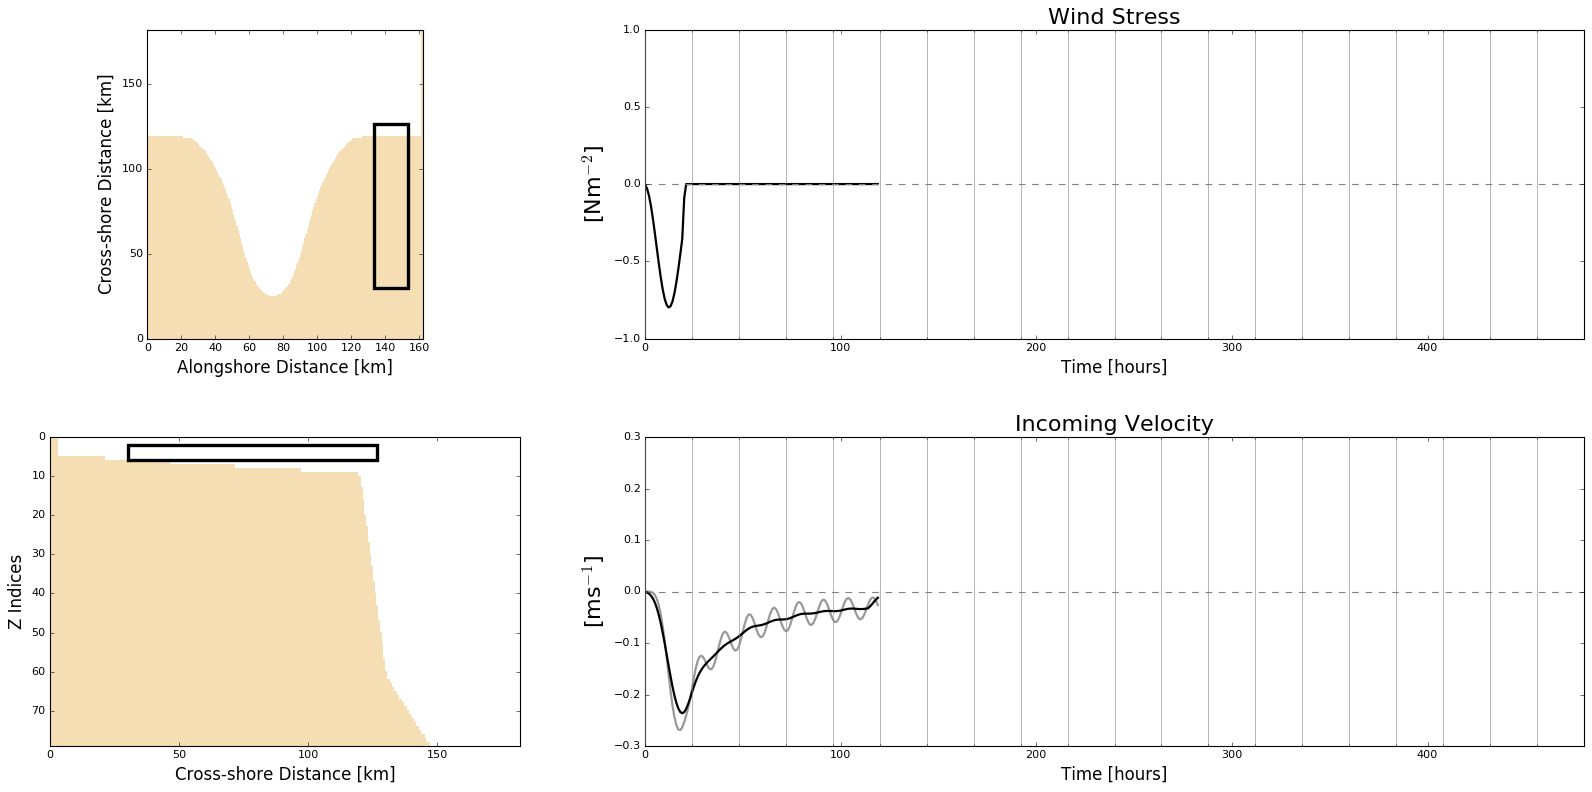

In [4]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_tanh_0.8_A/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

sozotauxPA, sozotauxCA = wind_timeseries(dirname)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

min unsmoothed:  -0.262808411512
min smoothed:  -0.193792564348


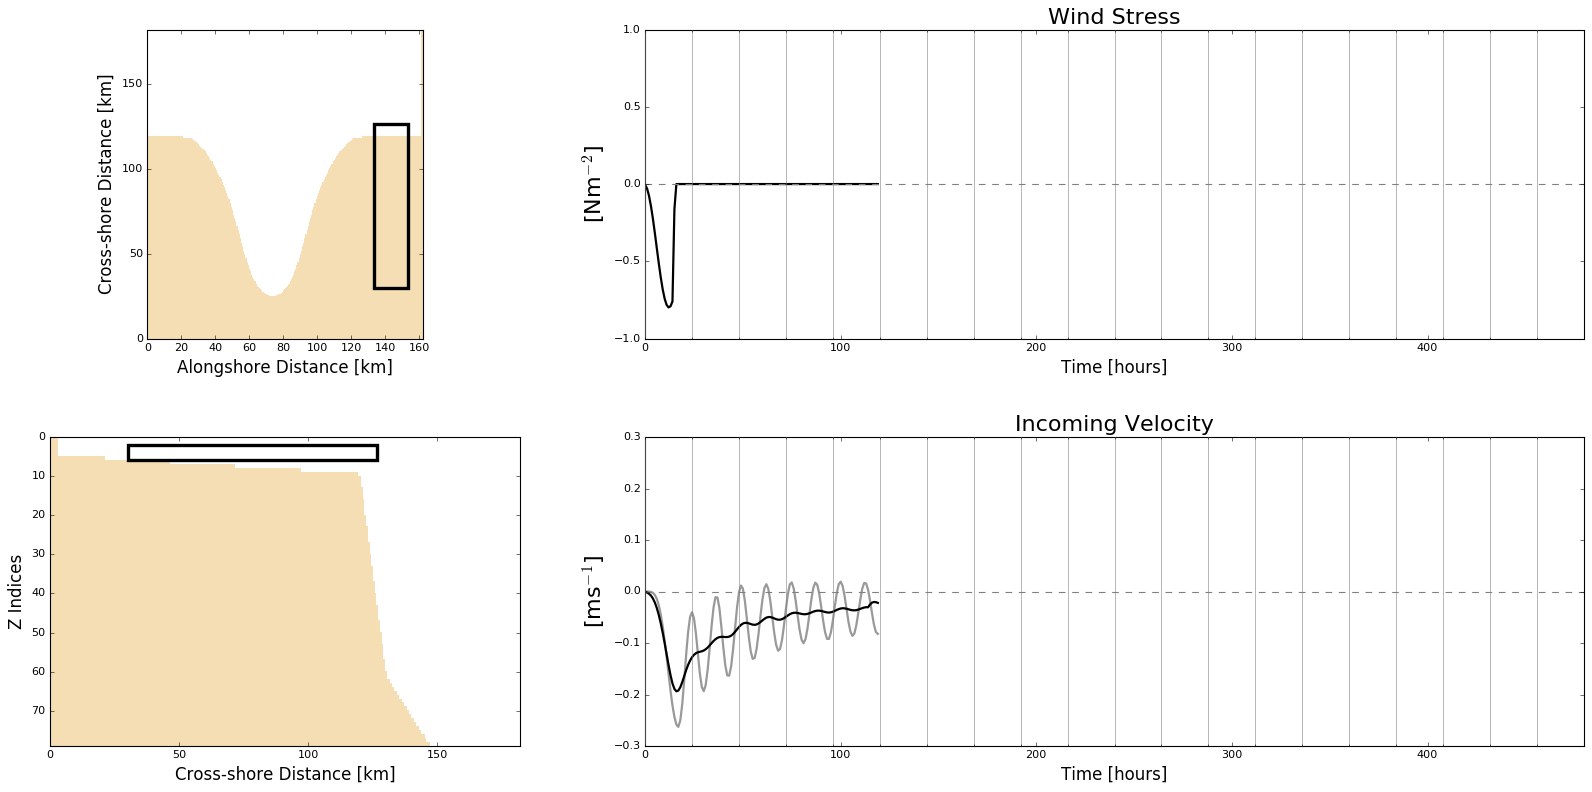

In [5]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_tanh_0.8_B/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

sozotauxPB, sozotauxCB = wind_timeseries(dirname)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

min unsmoothed:  -0.26281663537
min smoothed:  -0.193799469328


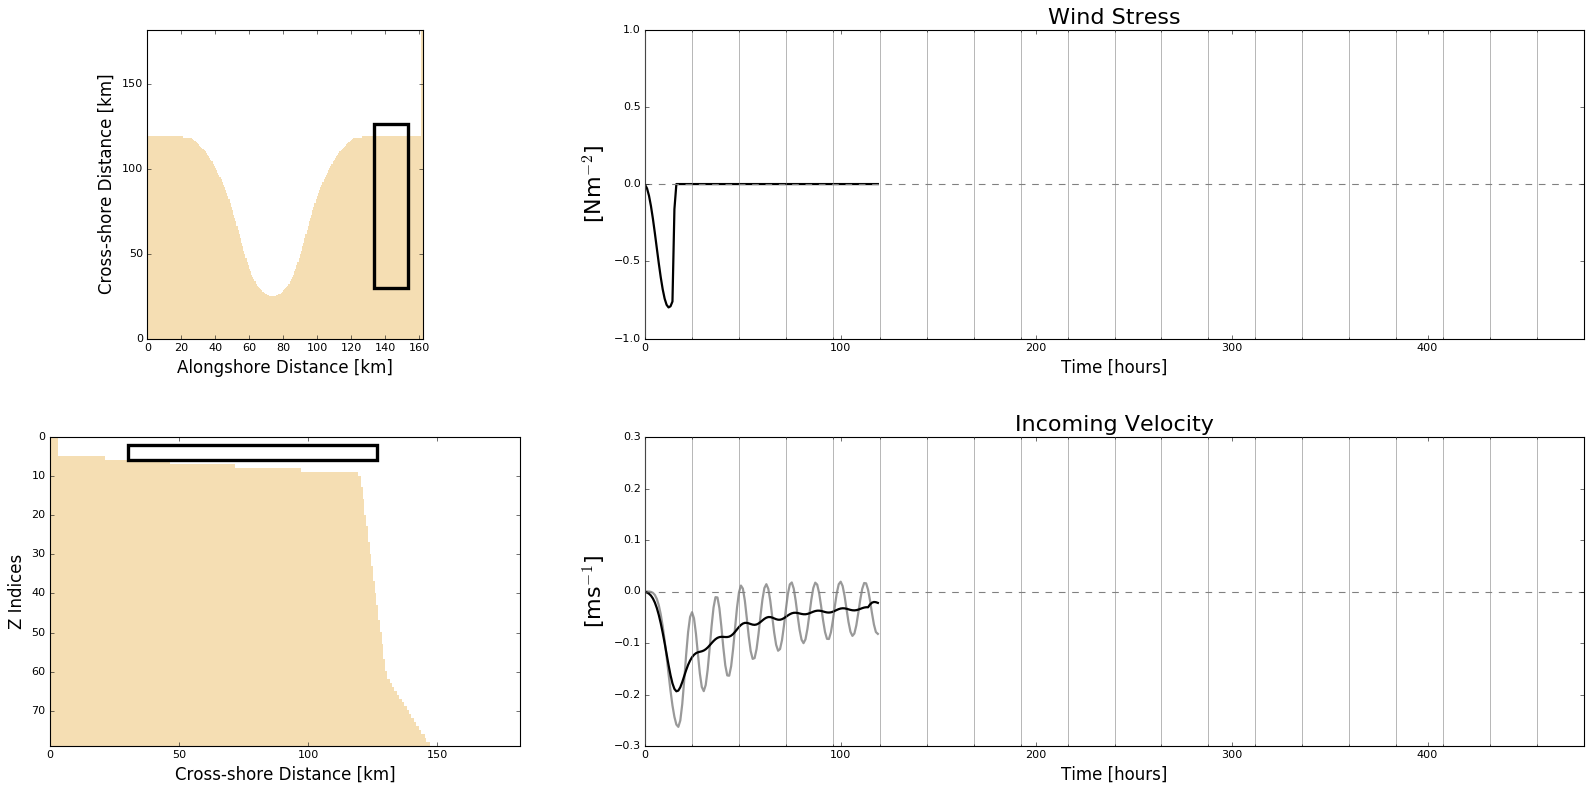

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_tanh_0.8_C/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

sozotauxPC, sozotauxCC = wind_timeseries(dirname)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

min unsmoothed:  -0.269117826991
min smoothed:  -0.237990973259


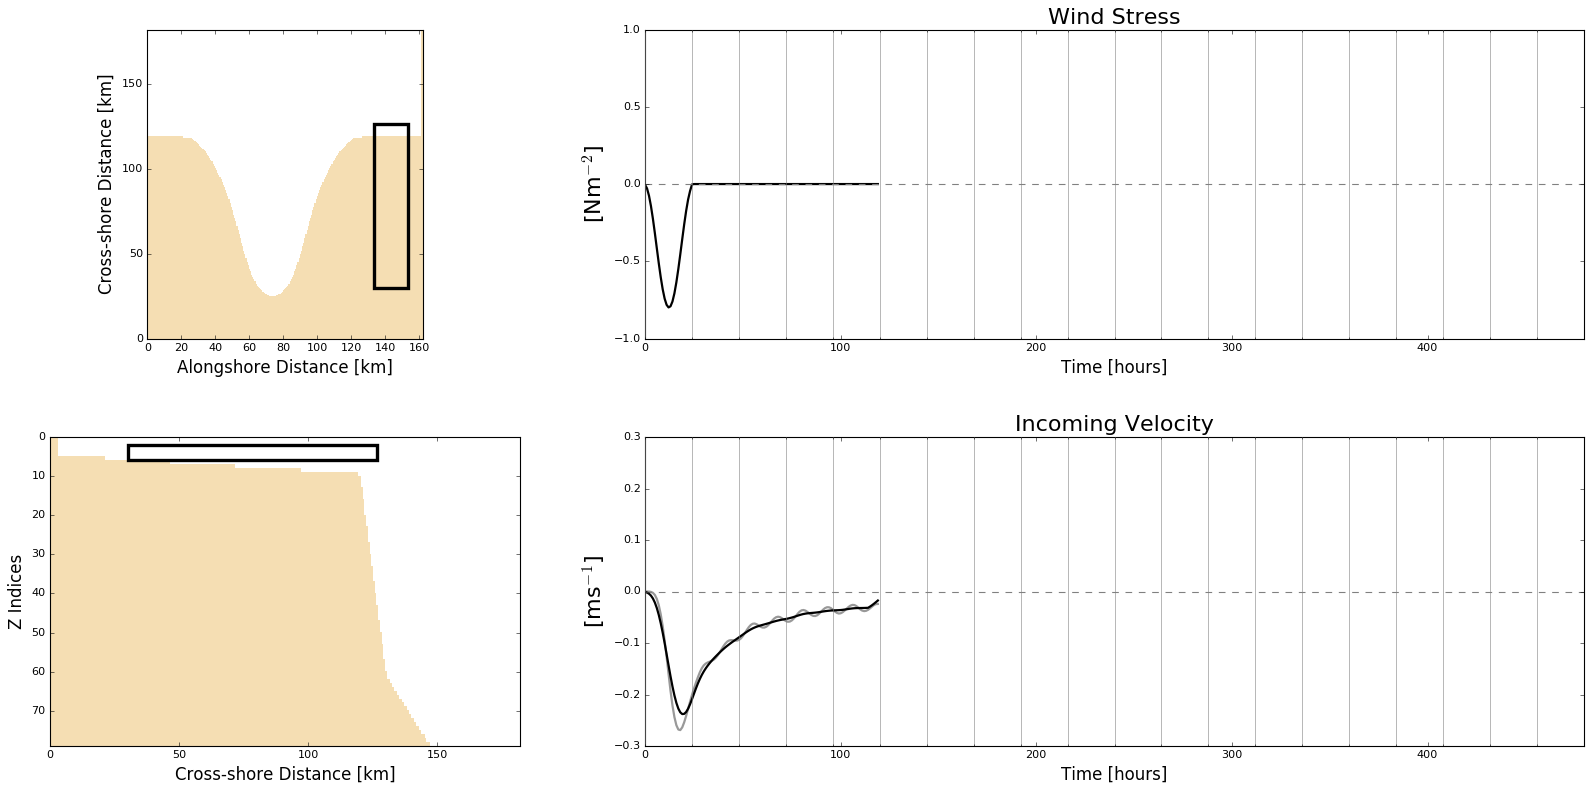

In [7]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/profile_cosine_tanh_0.8_D/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

sozotauxPD, sozotauxCD = wind_timeseries(dirname)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

# Tanh added to cosine

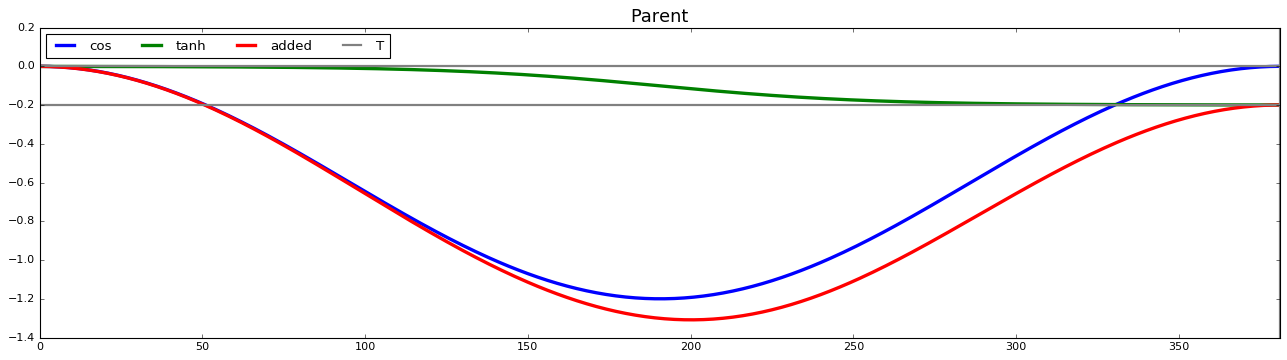

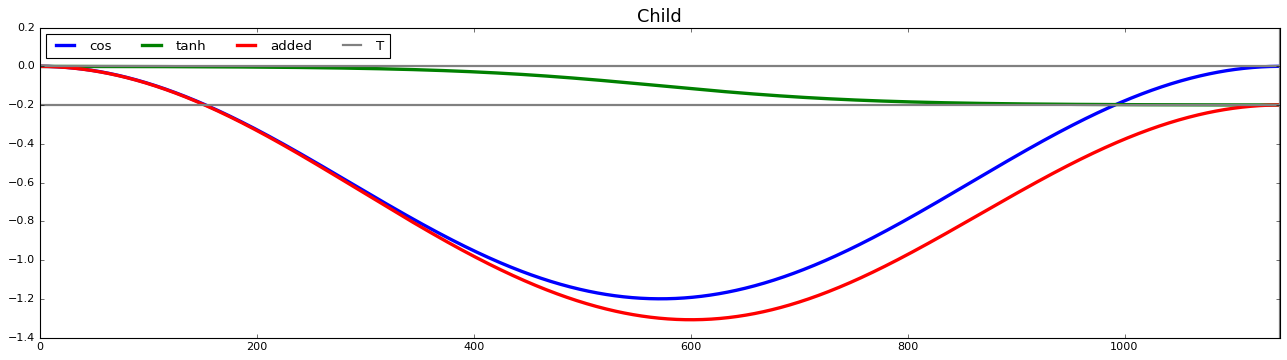

In [10]:
def plot_cosines(rn_rdt, period_ts, title):
    rn_utau = -1.2
    rn_utau2 = -0.2
    f = 0.0001373
    nn_tau = 91440
    nn_tau_step = (nn_tau / rn_rdt)
    kt_end = nn_tau_step + 200
    utau_orig = np.zeros(kt_end)
    utau_new1 = np.zeros(kt_end)
    utau_new2 = np.zeros(kt_end)
    utau_newA = np.zeros(kt_end)
    utau_newB = np.zeros(kt_end)
    utau_newC = np.zeros(kt_end)
    utau_newD = np.zeros(kt_end)
    
    def make_profile(utau_new, xm_frac, dx_frac):
        xm = int(nn_tau_step * xm_frac)
        dx = int(nn_tau_step * dx_frac)
        if kt <= xm:
            utau_new[kt] = rn_utau * ( 0.5 * (1 - np.cos ( (f * kt * rn_rdt) / 2 ) ) )
        elif kt > xm:
            ym = utau_new[xm]
            tanh_fxn = (-ym * np.tanh((kt - xm)/dx)) + ym
            utau_new[kt] = tanh_fxn
        x_end = xm + dx
        return utau_new, xm, x_end

    for kt in range(0, int(kt_end)):
        
        # original
        #utau_orig[kt] = rn_utau * ( 0.5 * (1 - np.cos ( (4 * np.pi * kt * rn_rdt) / (3 * nn_tau) ) ) )

        # second
        #utau_new1[kt] = rn_utau * ( 0.5 * (1 - np.cos ( (f * kt * rn_rdt) / (4 * np.pi) ) ) )

        # final
        utau_new2[kt] = rn_utau * ( 0.5 * (1 - np.cos ( (f * kt * rn_rdt) / (2) ) ) )
        
        # w/ tanh
        xm_frac, dx_frac = 0.8, 0.25
        utau_newA, xmA, x_endA = make_profile(utau_newA, xm_frac, dx_frac)
        
        xm_frac, dx_frac = 0.6, 0.5
        utau_newB, xmB, x_endB = make_profile(utau_newB, xm_frac, dx_frac)
        
        xm_frac, dx_frac = 0.6, 1.5
        utau_newC, xmC, x_endC = make_profile(utau_newC, xm_frac, dx_frac)
        
        xm_frac, dx_frac = 0.9, 1.5
        utau_newD, xmD, x_endD = make_profile(utau_newD, xm_frac, dx_frac)
        
    # --------------------------------------------------------------------------------
    
    cosonly = np.zeros(kt_end)
    tanhonly = np.zeros(kt_end)
    xm = int(nn_tau_step/2)
    dx = nn_tau_step / 6
    ym = rn_utau2 / 2
    
    for kt in range(0, int(nn_tau_step)):
        cosonly[kt] = rn_utau * ( 0.5 * (1 - np.cos ( (f * kt * rn_rdt) / (2) ) ) )
        tanhonly[kt] = ym * ( np.tanh( ( kt - xm ) / dx ) + 1 )
        
    for kt in range(int(nn_tau_step), int(kt_end)):
        cosonly[kt] = 0
        tanhonly[kt] = ym * ( np.tanh( ( kt - xm ) / dx ) + 1 )
        
    #for kt in range(0, int(kt_end)):
    #    tanhonly[kt] = ym * ( np.tanh( ( kt - xm ) / dx ) + 1 )

    utau_add = cosonly + tanhonly
    
    # --------------------------------------------------------------------------------
    labs =  ['cos', 'tanh', 'added']
    cs =    ['b', 'g', 'r']
    utaus = [cosonly, tanhonly, utau_add]
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    for n, this_utau, lab, c in zip(np.arange(len(utaus)), utaus, labs, cs):
        ax.plot(this_utau, label=lab, lw=3, c=c)
    ax.axhline(0, c='gray', linewidth=2)
    ax.axhline(-0.2, c='gray', linewidth=2)
    ax.axvline(period_ts, c='gray', linewidth=2, label='T')
    ax.legend(ncol=8, loc=2, fontsize=12)
    ax.set_title(title, fontsize=16)
    #ax.set_ylim([-1.5, 0.5])
    ax.set_xlim([0, period_ts])
    
    #if title == 'Parent':
    #    for i in range(1,25):
    #        ax.axvline(45*i, c='navy', linestyle='--')
    #    for xm, x_end, j in zip([xmA, xmB, xmC, xmD], [x_endA, x_endB, x_endC, x_endD], np.arange(1,len(cs)+1)):
    #        ax.axvline(xm, c=cs[j], lw=2)
    #        ax.axvline(x_end, c=cs[j], lw=2)
    return fig

rn_rdt = 240
period_ts = 381
fig = plot_cosines(rn_rdt, period_ts, 'Parent')

rn_rdt = 80
period_ts = 1143
fig = plot_cosines(rn_rdt, period_ts, 'Child')

        IF( kt <= nn_tau000_step ) THEN
                    zfact = 0.5 * (  1. - COS( ( 0.0001373 * REAL( kt, wp ) * rn_rdt ) / ( 2 ) ) )
                    ztx   = zfact * rn_utau0
                    zty   = zfact * rn_vtau0
                    cosonly = ztx
                    !utau(:,:) = ztx
                    vtau(:,:) = zty
                    zcoef = 1. / ( zrhoa * zcdrag )
                    zmod  = SQRT( ztx * ztx + zty * zty )
                    taum(:,:) = zmod
                    zmod = SQRT( zmod * zcoef )
                    wndm(:,:) = zmod
                 ENDIF

                 IF( kt > nn_tau000_step ) THEN
                    cosonly = 0
                 ENDIF

                 utau(:,:) = cosonly

min unsmoothed:  -0.269138151291
min smoothed:  -0.238013260166


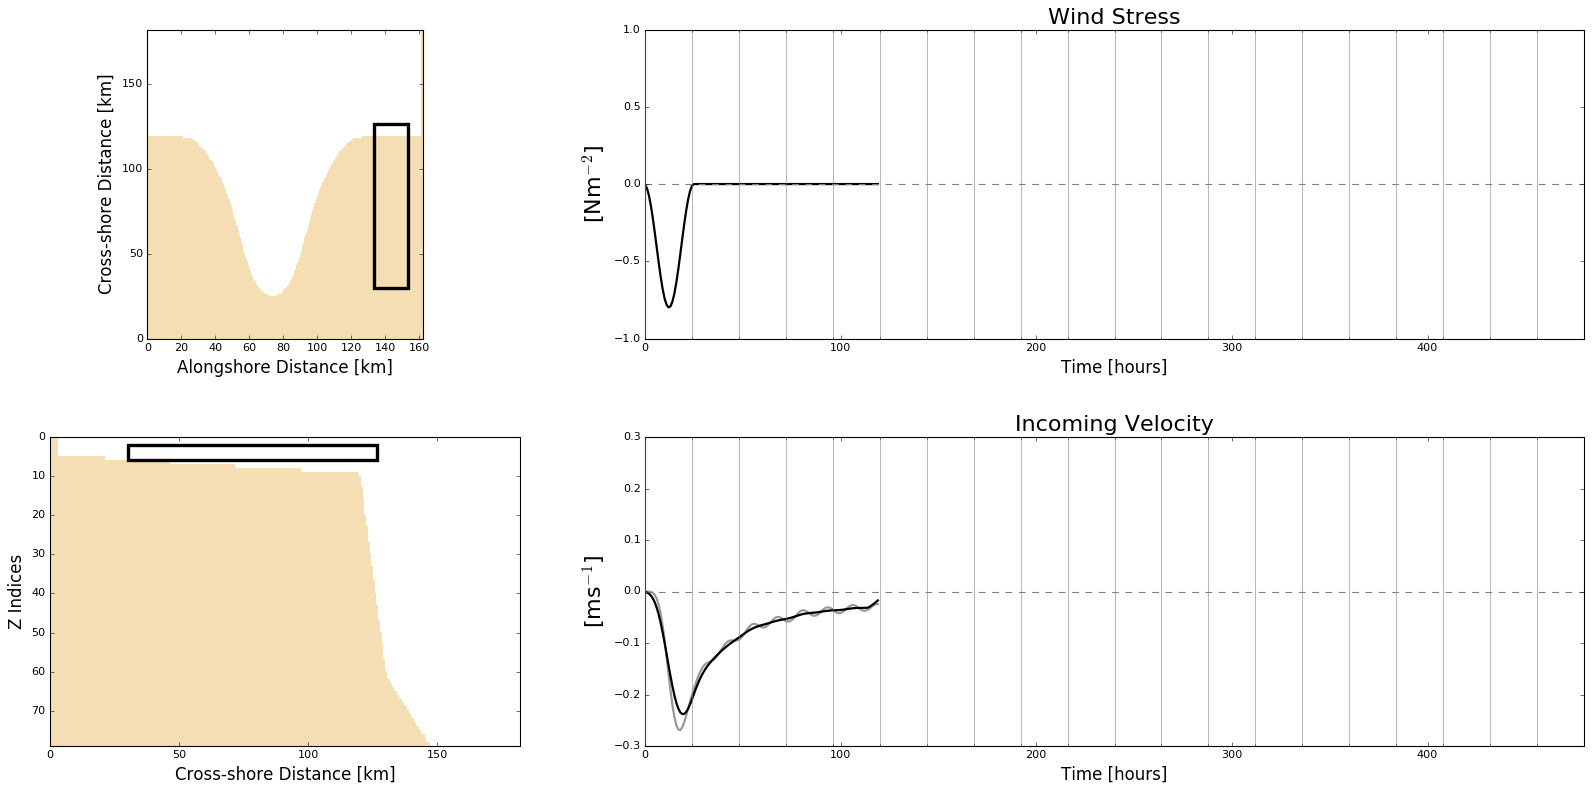

In [5]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/cosine_tanh_A/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

sozotauxP, sozotauxC = wind_timeseries(dirname)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

    ! Calculating variables to keep winds same for parent and child IAM
         nn_tau000_step = INT ( nn_tau000 / rn_rdt )
         xm = INT ( nn_tau000_step / 2 )
         dx = INT ( nn_tau000_step / 6 )
         ym = rn_utau1 / 2    
     
     IF( MOD( kt - 1, nn_fsbc ) == 0 ) THEN
         ! note to self, surface boundary condition variables are averaged at frequency of nn_fsbc timestep

         IF( kt <= nn_tau000_step ) THEN
            zfact = 0.5 * (  1. - COS( ( 0.0001373 * REAL( kt, wp ) * rn_rdt ) / ( 2 ) ) )
            ztx   = zfact * rn_utau0
            zty   = zfact * rn_vtau0
            cosonly = ztx
            tanhonly = ym * ( TANH ( ( REAL( kt, wp ) - xm ) / dx ) + 1 )
            !utau(:,:) = ztx
            vtau(:,:) = zty
            zcoef = 1. / ( zrhoa * zcdrag )
            zmod  = SQRT( ztx * ztx + zty * zty )
            taum(:,:) = zmod
            zmod = SQRT( zmod * zcoef )
            wndm(:,:) = zmod
         ENDIF

         IF( kt > nn_tau000_step ) THEN
            cosonly = 0
            tanhonly = ym * ( TANH ( ( REAL( kt, wp ) - xm ) / dx ) + 1 )
         ENDIF

         utau(:,:) = cosonly + tanhonly
         
         
        !-----------------------------------------------------------------------
        &namsbc_ana    !   analytical surface boundary condition
        !-----------------------------------------------------------------------
           nn_tau000   =   91440  !  seconds
           rn_utau0    =   -0.8   !  uniform value for the i-stress
           rn_utau1    =   -0.1
           rn_vtau0    =    0.0   !  uniform value for the j-stress

         
**Finally build successful!**

min unsmoothed:  -0.269143446005
min smoothed:  -0.238021075834


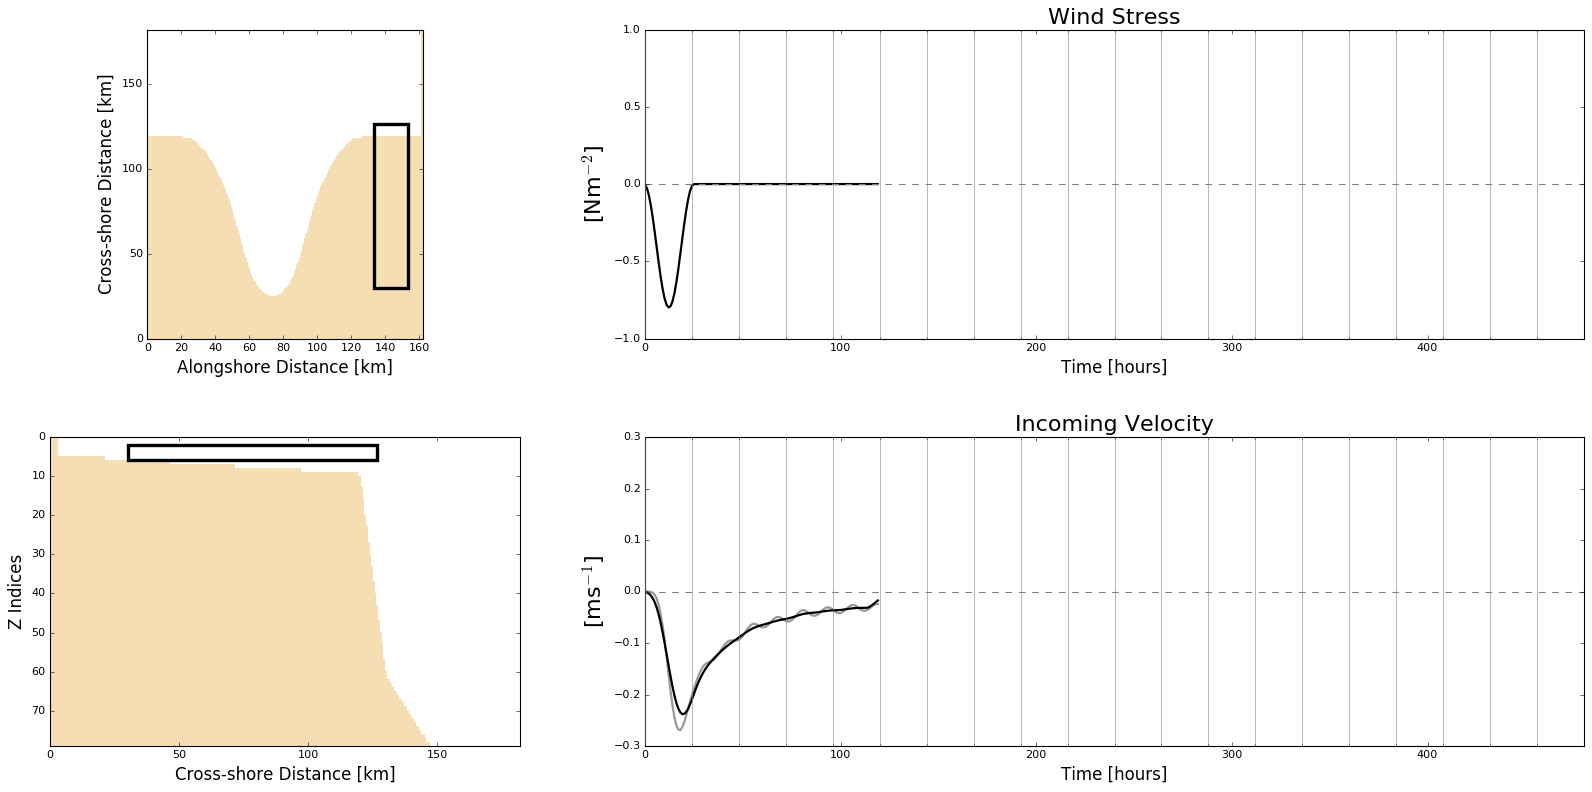

In [11]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/winds_incoming_velocities/added_cosine_tanh_built/'
fname = "1_MCKNZ_1h_20170101_20170105_*"

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

dep_inds_model = np.arange(vozocrtx.shape[-3])
dep_inds_box = np.arange(dep_start,dep_end+1)
y_inds = np.arange(y_start,y_end+1)

sozotauxP, sozotauxC = wind_timeseries(dirname)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

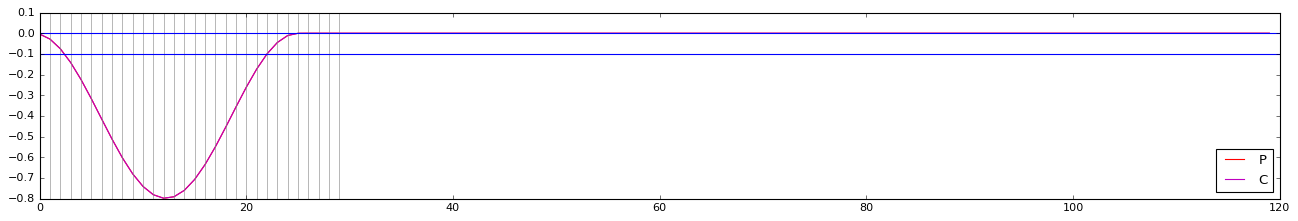

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20, 3))
ax.plot(sozotauxP, label='P', c='r')
ax.plot(sozotauxC, label='C', c='m')
ax.legend(loc=4)
for i in np.arange(30):
    ax.axvline(i, c='gray', linewidth=0.5)
ax.axhline(-0.1)
ax.axhline(0)

    /home/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/mackenzie03agrif/BLD/ppsrc/nemo/sbcana.f90(227): error #6911: The syntax of this substring is invalid.   [COSONLY]
            cosonly(:,:) = ztx
    ------------^
    compilation aborted for /home/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/mackenzie03agrif/BLD/ppsrc/nemo/sbcana.f90 (code 1)
    fcm_internal compile failed (256)
    make: *** [sbcana.o] Error 1
    make -f /home/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/mackenzie03agrif/BLD/Makefile -j 8 all failed (2) at /global/home/imachuca/NEMO-3.6-code/NEMOGCM/EXTERNAL/fcm/bin/../lib/Fcm/Build.pm line 597


or


    make: *** [sbcana.f90] Error 1
    make -f /home/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/mackenzie03agrif/OPAFILES/Makefile -j 1 all failed (2) at /global/home/imachuca/NEMO-3.6-code/NEMOGCM/EXTERNAL/fcm/bin/../lib/Fcm/Build.pm line 597